# User Segmentation

An example workthrough of user segmentation, with randomly generated user data.

## Imports

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#import from user_data_generator
from user_data_generator import UserDataGenerator # (don't need np,pd,datetime imports in this notebook if using default params)
from user_data_generator import assign_churn_conversion

# import from user_segmentation
from user_segmentation import UserSegmentationEngine

# user segmentation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. User Data Generation

Using the `UserDataGenerator` class to generate two sets of user data: an original set of users to fit the conversion and churn models to, and a new set of users on which to predict churn/conversion and to suggest interventions.

## 1.1. Original User Base

In [5]:
# instantiate UserDataGenerator object, creating the set of users

n = 400
total_days = 1000
udg = UserDataGenerator(n_users = n, time_back = total_days)

In [9]:
# parameters for generating new random data

np.random.seed(10)

session_params = {
    'session_rates': (np.arange(n)%4 + 2)*12 + 10,
    'session_duration_rates': (np.arange(n)%4 + 1)/40,
    'purchase_probabilities': np.random.beta(a = np.arange(n)%5 + 1, b = 5 - np.arange(n)%5),
    'purchase_means': (np.arange(n)%7 + 1) * 25,
    'mobile_probabilities': np.random.beta(a = np.arange(n)%3+1, b = 3-np.arange(n)%3),
    'random_seed': 4,
}
feature_params = {
    'n_features': 50,
    'feature_release_distribution': np.random.beta,
    'feature_adoption_probabilities': np.random.beta(a = (np.arange(n)+1)%5+1, b = 5-(np.arange(n)+1)%5),
    'random_seed': 5,
    'a': 1,
    'b': 1.5,
}
email_params = {
    'email_open_probabilities': np.random.beta(a = np.arange(n)%5 + 1, b = 5 - np.arange(n)%5),
    'email_frequency': 8,
    'random_seed': 6,
}
ticket_params = {
    'support_ticket_rates': 10 + 12*((np.arange(n)+3)%6)**2,
    'support_ticket_resolution_rates': (np.arange(n)%4 + 2)/5,
    'random_seed': 7,
}
referral_params = {
    'n_referrals': int(n*2.5),
    'referral_rates': (np.arange(n)+1)%5,
    'random_seed': 8,
}

In [11]:
# create usage data for users

dfs = udg.generate_all_data(
    args_sessions = session_params,
    args_features = feature_params,
    args_emails = email_params,
    args_support_tickets = ticket_params,
    args_referrals = referral_params,
)

In [13]:
# get usage statistics for users

df_stats = udg.get_user_data_statistics()

In [15]:
df_stats.head()

,user_id,days_since_signup,sessions_last_30d,days_since_last_visit,avg_session_duration_sec,avg_session_purchase_amount,total_spend,avg_session_purchase_probability,mobile_usage_pct,weekend_usage_pct,feature_adoption_rate,email_open_pct,support_tickets,referrals_made,referral_rate
0,user_0,435,0.0,50,2845.545455,10.454545,115,0.454545,0.0,0.272727,0.571429,0.000000,2.0,2.0,0.004598
1,user_1,25,1.0,25,2442.000000,0.000000,0,0.000000,0.0,1.000000,0.000000,0.250000,0.0,0.0,0.000000
2,user_2,549,1.0,16,4861.666667,30.333333,273,0.444444,0.0,0.222222,0.809524,0.376812,2.0,6.0,0.010929
3,user_3,435,0.0,66,11285.375000,50.250000,402,0.500000,0.0,0.250000,0.785714,0.418182,40.0,7.0,0.016092
4,user_4,420,1.0,27,983.666667,129.666667,778,1.000000,0.0,0.666667,0.000000,0.962264,20.0,0.0,0.000000


In [17]:
# assign noisy churn/conversion scores for users

df_stats_cc = assign_churn_conversion(df_stats)

In [19]:
df_stats_cc.head()

,user_id,days_since_signup,sessions_last_30d,days_since_last_visit,avg_session_duration_sec,avg_session_purchase_amount,total_spend,avg_session_purchase_probability,mobile_usage_pct,weekend_usage_pct,feature_adoption_rate,email_open_pct,support_tickets,referrals_made,referral_rate,churned,converted
0,user_0,435,0.0,50,2845.545455,10.454545,115,0.454545,0.0,0.272727,0.571429,0.000000,2.0,2.0,0.004598,1,0
1,user_1,25,1.0,25,2442.000000,0.000000,0,0.000000,0.0,1.000000,0.000000,0.250000,0.0,0.0,0.000000,1,0
2,user_2,549,1.0,16,4861.666667,30.333333,273,0.444444,0.0,0.222222,0.809524,0.376812,2.0,6.0,0.010929,0,0
3,user_3,435,0.0,66,11285.375000,50.250000,402,0.500000,0.0,0.250000,0.785714,0.418182,40.0,7.0,0.016092,0,0
4,user_4,420,1.0,27,983.666667,129.666667,778,1.000000,0.0,0.666667,0.000000,0.962264,20.0,0.0,0.000000,1,0


## 1.2. New Set of Users

We will predict segment/churn/conversion for these users, based on segmentation/churn/conversion models fit on the first set of users.

In [22]:
n = 250
total_days = 1000
udg_new = UserDataGenerator(n_users = n, time_back = total_days, random_seed=2)

np.random.seed(20)

session_params = {
    'session_rates': (np.arange(n)%4 + 2)*12 + 10,
    'session_duration_rates': (np.arange(n)%4 + 1)/40,
    'purchase_probabilities': np.random.beta(a = np.arange(n)%5 + 1, b = 5 - np.arange(n)%5),
    'purchase_means': (np.arange(n)%7 + 1) * 25,
    'mobile_probabilities': np.random.beta(a = np.arange(n)%3+1, b = 3-np.arange(n)%3),
    'random_seed': 4,
}
feature_params = {
    'n_features': 50,
    'feature_release_distribution': np.random.beta,
    'feature_adoption_probabilities': np.random.beta(a = (np.arange(n)+1)%5+1, b = 5-(np.arange(n)+1)%5),
    'random_seed': 5,
    'a': 1,
    'b': 1.5,
}
email_params = {
    'email_open_probabilities': np.random.beta(a = np.arange(n)%5 + 1, b = 5 - np.arange(n)%5),
    'email_frequency': 8,
    'random_seed': 6,
}
ticket_params = {
    'support_ticket_rates': 10 + 12*((np.arange(n)+3)%6)**2,
    'support_ticket_resolution_rates': (np.arange(n)%4 + 2)/5,
    'random_seed': 7,
}
referral_params = {
    'n_referrals': int(n*2.5),
    'referral_rates': (np.arange(n)+1)%5,
    'random_seed': 8,
}

In [24]:
dfs_new = udg_new.generate_all_data(
    args_sessions = session_params,
    args_features = feature_params,
    args_emails = email_params,
    args_support_tickets = ticket_params,
    args_referrals = referral_params,
)

df_new_stats = udg_new.get_user_data_statistics()

In [26]:
df_new_stats.head()

,user_id,days_since_signup,sessions_last_30d,days_since_last_visit,avg_session_duration_sec,avg_session_purchase_amount,total_spend,avg_session_purchase_probability,mobile_usage_pct,weekend_usage_pct,feature_adoption_rate,email_open_pct,support_tickets,referrals_made,referral_rate
0,user_0,435,0.0,50,2845.545455,10.454545,115,0.454545,0.0,0.272727,0.454545,0.240741,2.0,0.0,0.000000
1,user_1,25,1.0,25,2442.000000,0.000000,0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,2.0,0.080000
2,user_2,549,1.0,24,5727.625000,16.875000,135,0.250000,0.0,0.000000,0.565217,0.367647,2.0,4.0,0.007286
3,user_3,435,0.0,61,2508.800000,62.600000,313,0.600000,0.0,0.400000,0.909091,0.907407,40.0,2.0,0.004598
4,user_4,420,0.0,52,1035.000000,82.363636,906,0.636364,0.0,0.181818,0.300000,0.826923,20.0,0.0,0.000000


# 2. User Segmentation

## 2.1. Create User Segments

We will use K-Means to group users into clusters.

In [32]:
# instantiate UserSegmentationEngine object to handle the segmentation/churn/conversion models

seg_engine = UserSegmentationEngine()


In [34]:
# fit segmentation models on stats from original user base

df_segments = seg_engine.create_user_segments(
    df=df_stats_cc,
    features=['sessions_last_30d','days_since_last_visit','avg_session_duration_sec','avg_session_purchase_amount','avg_session_purchase_probability','email_open_pct','feature_adoption_rate','referral_rate'],
    n_clusters=5,
)

Silhouette score: 0.175
Segment Profiles
--------------------------------------------------------------------------------
* Segment: 2
    name: 2
    size: 99
    size_pct: 0.2475
    avg_sessions_30d: 0.0
    avg_spend: 190.32323232323233
    avg_churn_rate: 0.6868686868686869
    avg_conversion_rate: 0.010101010101010102
    characteristics:
      sessions_last_30d: {'mean': 0.0, 'deviation': -1.0}
      days_since_last_visit: {'mean': 68.86868686868686, 'deviation': 0.36104124246416724}
      avg_session_duration_sec: {'mean': 4832.219581691918, 'deviation': -0.10775696859850366}
      avg_session_purchase_amount: {'mean': 16.67195329512052, 'deviation': -0.6677553497830092}
      avg_session_purchase_probability: {'mean': 0.1918041395667264, 'deviation': -0.6219761973085832}
      email_open_pct: {'mean': 0.29015072680235887, 'deviation': -0.4165668930775784}
      feature_adoption_rate: {'mean': 0.49110264251926516, 'deviation': 0.02698008390928615}
      referral_rate: {'mean': 

## 2.2. Train Churn and Conversion Models

In [37]:
# train churn model

seg_engine.train_model(
    df=df_segments,
    model=GradientBoostingClassifier(),
    target='churned',
    features=['days_since_signup','sessions_last_30d','days_since_last_visit','avg_session_duration_sec',
             'avg_session_purchase_amount','avg_session_purchase_probability', 'feature_adoption_rate','email_open_pct',
             'support_tickets','referrals_made', 'referral_rate'],
)

Prediction Model: churned
--------------------------------------------------------------------------------
ROC-AUC Score: 0.7407924107142857
              precision    recall  f1-score   support

 not churned       0.64      0.75      0.69        56
     churned       0.74      0.62      0.68        64

    accuracy                           0.68       120
   macro avg       0.69      0.69      0.68       120
weighted avg       0.69      0.68      0.68       120


Top churned Predictors:
 *  days_since_last_visit:  0.322
 *  feature_adoption_rate:  0.310
 *  days_since_signup:  0.079
 *  avg_session_duration_sec:  0.057
 *  avg_session_purchase_amount:  0.053
 *  email_open_pct:  0.053
 *  referral_rate:  0.050
 *  support_tickets:  0.040
 *  referrals_made:  0.016
 *  sessions_last_30d:  0.012
 *  avg_session_purchase_probability:  0.008


{'auc': 0.7407924107142857,
 'feature_importance':                              feature  importance
 2              days_since_last_visit    0.321934
 6              feature_adoption_rate    0.310409
 0                  days_since_signup    0.078770
 3           avg_session_duration_sec    0.056663
 4        avg_session_purchase_amount    0.053059
 7                     email_open_pct    0.052630
 10                     referral_rate    0.050076
 8                    support_tickets    0.039529
 9                     referrals_made    0.016478
 1                  sessions_last_30d    0.012473
 5   avg_session_purchase_probability    0.007979}

In [39]:
# train conversion model

seg_engine.train_model(
    df=df_segments,
    model=GradientBoostingClassifier(),
    target='converted',
    features=['days_since_signup','sessions_last_30d','days_since_last_visit','avg_session_duration_sec',
             'avg_session_purchase_amount','avg_session_purchase_probability', 'feature_adoption_rate','email_open_pct',
             'support_tickets','referrals_made', 'mobile_usage_pct','weekend_usage_pct','total_spend'],
)

Prediction Model: converted
--------------------------------------------------------------------------------
ROC-AUC Score: 0.7808695652173914
               precision    recall  f1-score   support

not converted       0.97      1.00      0.98       115
    converted       1.00      0.20      0.33         5

     accuracy                           0.97       120
    macro avg       0.98      0.60      0.66       120
 weighted avg       0.97      0.97      0.96       120


Top converted Predictors:
 *  feature_adoption_rate:  0.235
 *  avg_session_duration_sec:  0.231
 *  days_since_last_visit:  0.139
 *  avg_session_purchase_amount:  0.099
 *  email_open_pct:  0.094
 *  referrals_made:  0.077
 *  weekend_usage_pct:  0.035
 *  avg_session_purchase_probability:  0.028
 *  sessions_last_30d:  0.024
 *  days_since_signup:  0.020
 *  support_tickets:  0.011
 *  total_spend:  0.007
 *  mobile_usage_pct:  0.000


{'auc': 0.7808695652173914,
 'feature_importance':                              feature  importance
 6              feature_adoption_rate    0.235271
 3           avg_session_duration_sec    0.230740
 2              days_since_last_visit    0.138735
 4        avg_session_purchase_amount    0.099086
 7                     email_open_pct    0.093973
 9                     referrals_made    0.077296
 11                 weekend_usage_pct    0.035276
 5   avg_session_purchase_probability    0.028412
 1                  sessions_last_30d    0.024283
 0                  days_since_signup    0.019694
 8                    support_tickets    0.010617
 12                       total_spend    0.006619
 10                  mobile_usage_pct    0.000000}

## 2.3. Compute Likelihoods of Churn/Conversion on Original Data

We will go back and predict the likelihoods of churn and conversion on the users from the original data, using the models we just fit on the data. 

We will also visualize the churn/conversion of the segments of the group.

In [36]:
#df_cc_likelihood = seg_engine.score_users(df_stats)
df_cc_likelihood = seg_engine.score_users(df_segments)

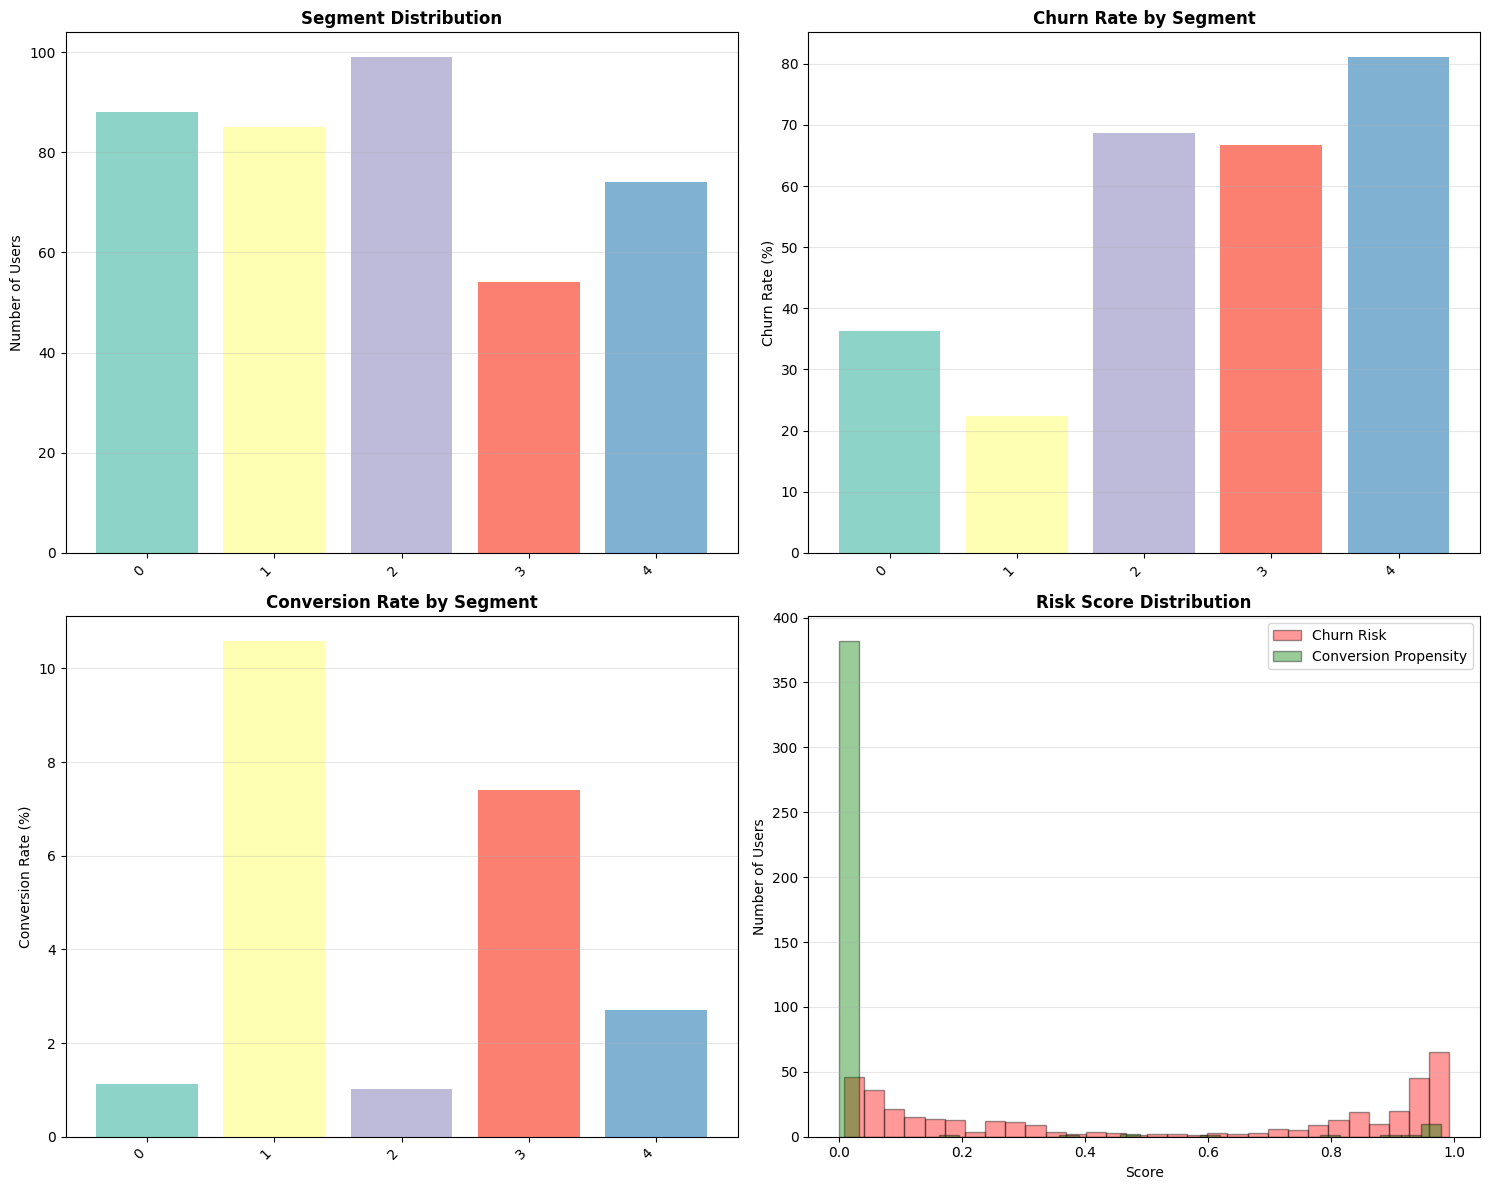

In [38]:
seg_engine.visualize_segments(df_cc_likelihood)

## 2.4. Predict Segments/Churn/Conversion for New User Base

We will now use the earlier-fitted models on the data from the new users

In [45]:
# predict segments of new users

df_new_segments = seg_engine.predict_user_segments(df_new_stats)

Silhouette score: 0.185


In [43]:
df_new_segments.head()

,user_id,days_since_signup,sessions_last_30d,days_since_last_visit,avg_session_duration_sec,avg_session_purchase_amount,total_spend,avg_session_purchase_probability,mobile_usage_pct,weekend_usage_pct,feature_adoption_rate,email_open_pct,support_tickets,referrals_made,referral_rate,segment
0,user_0,435,0.0,50,2845.545455,10.454545,115,0.454545,0.0,0.272727,0.454545,0.240741,2.0,0.0,0.000000,2
1,user_1,25,1.0,25,2442.000000,0.000000,0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,2.0,0.080000,1
2,user_2,549,1.0,24,5727.625000,16.875000,135,0.250000,0.0,0.000000,0.565217,0.367647,2.0,4.0,0.007286,0
3,user_3,435,0.0,61,2508.800000,62.600000,313,0.600000,0.0,0.400000,0.909091,0.907407,40.0,2.0,0.004598,1
4,user_4,420,0.0,52,1035.000000,82.363636,906,0.636364,0.0,0.181818,0.300000,0.826923,20.0,0.0,0.000000,4


In [47]:
# predict churn/conversion likelihoods of new users

df_new_cc_likelihood = seg_engine.score_users(df_new_segments)

In [49]:
df_new_cc_likelihood.head()

,user_id,days_since_signup,sessions_last_30d,days_since_last_visit,avg_session_duration_sec,avg_session_purchase_amount,total_spend,avg_session_purchase_probability,mobile_usage_pct,weekend_usage_pct,feature_adoption_rate,email_open_pct,support_tickets,referrals_made,referral_rate,segment,churn_likelihood,conversion_likelihood,churn_risk_category,conversion_likelihood_category
0,user_0,435,0.0,50,2845.545455,10.454545,115,0.454545,0.0,0.272727,0.454545,0.240741,2.0,0.0,0.000000,2,0.911093,0.000341,high,low
1,user_1,25,1.0,25,2442.000000,0.000000,0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,2.0,0.080000,1,0.288611,0.000148,low,low
2,user_2,549,1.0,24,5727.625000,16.875000,135,0.250000,0.0,0.000000,0.565217,0.367647,2.0,4.0,0.007286,0,0.319221,0.000875,medium,low
3,user_3,435,0.0,61,2508.800000,62.600000,313,0.600000,0.0,0.400000,0.909091,0.907407,40.0,2.0,0.004598,1,0.588082,0.000634,medium,low
4,user_4,420,0.0,52,1035.000000,82.363636,906,0.636364,0.0,0.181818,0.300000,0.826923,20.0,0.0,0.000000,4,0.875002,0.000432,high,low


## 2.5. Recommend Interventions for New Users

In [52]:
df_new_recs = seg_engine.recommend_intervention(df_new_cc_likelihood)

In [54]:
df_new_recs

,user_id,segment,churn_likelihood,conversion_likelihood,priority,intervention,message,estimated_ltv
0,user_18,3,0.807,0.554,2,Targetted discount offer,Limited discount on subscription upgrade,1068
1,user_104,4,0.977,0.002,3,Targetted re-engagement email campaign,Testimonials,6324
2,user_209,4,0.814,0.001,3,Targetted re-engagement email campaign,Testimonials,8794
3,user_96,2,0.971,0.001,3,Targetted re-engagement email campaign,Testimonials,3888
4,user_34,4,0.977,0.001,3,Targetted re-engagement email campaign,Testimonials,3544
5,user_74,4,0.975,0.001,3,Targetted re-engagement email campaign,Testimonials,3230
6,user_39,4,0.976,0.007,3,Targetted re-engagement email campaign,Testimonials,2592
7,user_242,3,0.974,0.000,3,Targetted re-engagement email campaign,Testimonials,2766
8,user_83,3,0.899,0.175,3,Targetted re-engagement email campaign,Testimonials,1306
9,user_179,3,0.941,0.001,3,Targetted re-engagement email campaign,Testimonials,3332
